<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/TensorFlow_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tf-nightly  # Requires tf 1.13

In [0]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd

import tensorflow as tf


In [0]:
tf.enable_eager_execution()

In [0]:
#tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

In [0]:
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval  = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')

y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [46]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [47]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [62]:
dftrain.shape, dfeval.shape

((627, 9), (264, 9))

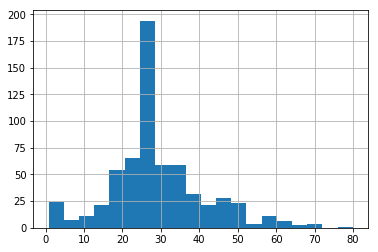

In [49]:
dftrain.age.hist(bins=20)

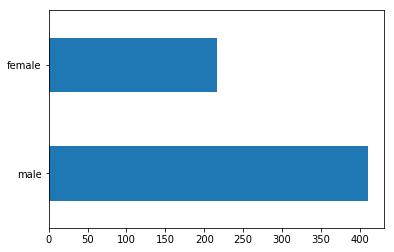

In [50]:
dftrain.sex.value_counts().plot(kind='barh')

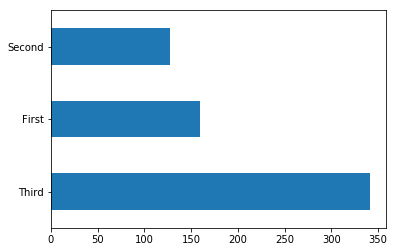

In [51]:
dftrain['class'].value_counts().plot(kind='barh')

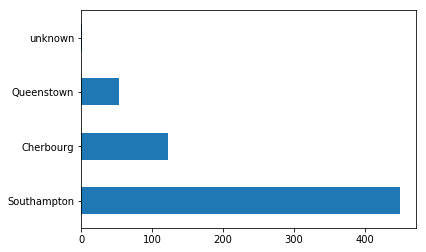

In [52]:
dftrain["embark_town"].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

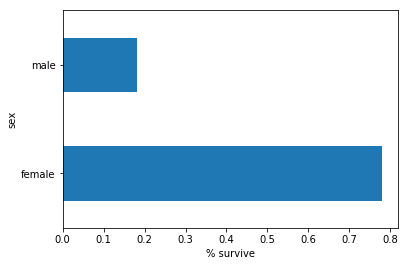

In [53]:
ax = (pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh'))
ax.set_xlabel("% survive")

In [0]:
fc = tf.feature_column

CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name, vocab)
  )

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

In [0]:
NUMERIC_COLUMNS = ['age', 'fare']

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))

In [56]:
example = dftrain.head(1)
class_fc = one_hot_cat_column('class', ('First', 'Second', 'Third'))
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', fc.input_layer(dict(example), [class_fc]).numpy())

Feature value: "Third"
One-hot encoded:  [[0. 0. 1.]]


In [57]:
fc.input_layer(dict(example), feature_columns)

<tf.Tensor: id=9611, shape=(1, 34), dtype=float32, numpy=
array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)>

In [0]:
NUM_EXAMPLES = len(y_train)

In [0]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    dataset = dataset.repeat(n_epochs)
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

In [0]:
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval)

In [0]:
# Linear Model to bench-mark
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train
linear_est.train(train_input_fn, max_steps=100)

results = linear_est.evaluate(eval_input_fn)

print("Accuracy ", results["accuracy"])
print("Dummy Model", results["accuracy_baseline"])

In [0]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 


n_batches = 1

est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batches)
est.train(train_input_fn, max_steps=100)

results = est.evaluate(eval_input_fn)

print("Accuracy ", results["accuracy"])
print("Boosted Tree Model", results["accuracy_baseline"])

In [0]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([ pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title="predicted probabilities")